# Annotation round 1 - Post scVI QC

In [121]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [122]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/annotation_lift2NEW/"
if not os.path.exists(figdir):
    os.mkdir(figdir)
sc.settings.figdir = figdir

In [62]:
## Load existing annotation
obs = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv', index_col = 0) # final annotations and removed maternal contaminant cells

## Load annotation groups
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)

## LYMPHOID_NEW

In [187]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/'
spl = 'LYMPHOID_NEW'
adata = sc.read_h5ad(data_dir + f"PAN.A01.v01.entire_data_normalised_log.20210429.{spl}.h5ad")
adata.var_names_make_unique()

In [188]:
## Load old annotations
adata.obs['annotation_obs'] = obs.loc[adata.obs_names]['anno_lvl_2_final_clean']

... storing 'annotation_obs' as categorical


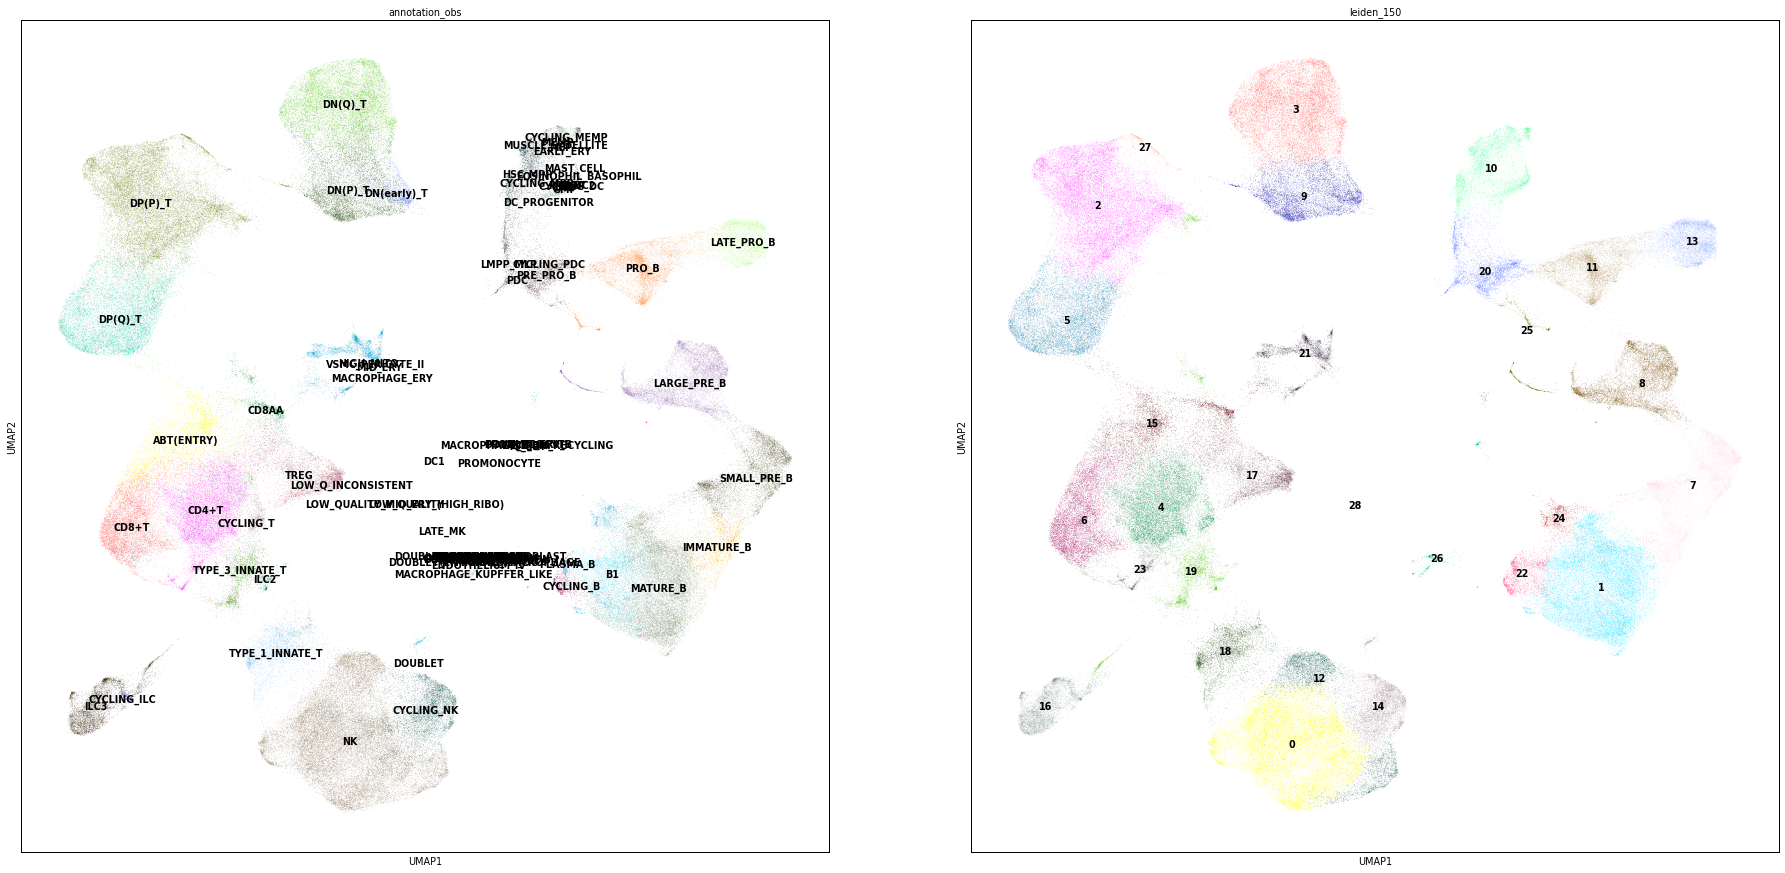

In [189]:
plt.rcParams['figure.figsize'] = [15,15]
sns.set_context("paper")
sc.pl.umap(adata, color=['annotation_obs', 'leiden_150'], legend_loc='on data', save='UMAPs_LYMPHOID_NEW.png')

In [191]:
# markers = pd.read_csv('../../metadata/marker_genes/B_marker_genes_09072021_clean.csv', index_col=0)
# markers_dict = {a:markers.loc[markers['anno_lvl_2']==a, 'gene'].tolist() for a in markers['anno_lvl_2'].unique()}
markers = {
            ## Progenitors
            'HSC_MPP':['CLEC9A','HLF','CD34','SPINK2'],
           'MLP':['BCL11A','IL7R','IL2RG'],
           'B lineage':['CD19','VPREB1','PAX5'],
           'T lineage':['CD3D','BCL11B'],
           'MEMP':['GATA2'],
           'MEP':['KLF1','ITGA2B'],
           'Ery lineage':['HBB','HBG1'],
           'Myeloid lineage':['MPO','CSF1R','CEBPA'],
            ## B cells
            'lymphoid progenitor':['CD34','SPINK2','IL7R','KIT'],
           'PRE PRO B':['FLT3','CD19','VPREB1'], 
           'PRO B':['MME','CDC45','DHFR','MKI67'], 
           'LATE PRO B':['CD27','RAG1','DNTT','VPREB3'], 
           'PRO -> PRE':['CD24','TNFRSF17'], 
           'PRE -> IMMATURE':['MME','IDH2','SPIB','IL4R','IGHM'], 
           'MATURE':['IGHD','MS4A1','CD40','FCER2'], 
           'B1':['CD27','SPN','CCR10'],
           'PLASMA B':['JCHAIN','SDC1','CD38'],
           'CYCLING_B':['MKI67'],
           ## T cells
           'DN(early)':['IGLL1','ST18'],
           'DN(P)':['TRGC2','TRDC','HIVEP3'],
           'DN(Q)':['RAG1','RAG2','TP53INP1','PTCRA','RGPD3'],
           'DP(P)':['SMPD3'], 
           'DP(Q)':['AQP3','RORC'], 
           'abT(entry)':['CCR9','SATB1','TOX2'], 
           'MATURE_T':['CCR7','CD5','CD27','CD8A','CD8B','CD4'], 
           'Treg':['FOXP3','CTLA4'], 
           'CD8aa':['PDCD1','GNG4','ZNF683'], 
           'innate':['KLRB1','ZBTB16'],
           'TYPE_3_INNATE_T':['CD40LG','RORC','CCR6','ANXA1'],
           'ILC3': ['RORC','IL1R1','IL23R','KIT'],
           'ILC2':['PTGDR2','HPGDS','GATA3'],
           'TYPE_1_INNATE_T':['NKG7','EOMES','TBX21','IFNG-AS1'],
           'NK': ['KLRD1','KLRF1','NKG7','NCAM1'],
           'CYCLING':['MKI67'],
          }

cell_type_order = [
    ## B cell order
    'LMPP_MLP','PRE_PRO_B','PRO_B','LATE_PRO_B','LARGE_PRE_B','SMALL_PRE_B','IMMATURE_B','MATURE_B','B1','PLASMA_B','CYCLING_B',
    ## T cells order
    'DN(early)_T','DN(P)_T','DN(Q)_T','DP(P)_T','DP(Q)_T','ABT(ENTRY)','CD8+T',
    'CD4+T','TREG','CYCLING_T','CD8AA','TYPE_3_INNATE_T','ILC3','ILC2','CYCLING_ILC',
    'TYPE_1_INNATE_T','NK','CYCLING_NK'
]

cell_type_order = anno_groups_dict['PROGENITORS'] + cell_type_order + anno_groups_dict['OTHER']

### Confusion matrix

In [192]:
conf_mat = sc.metrics.confusion_matrix( 'leiden_150', 'annotation_obs', adata.obs, normalize=True).T

## Keep cts that make up at least 1% of a cluster
keep_cts_ixs = np.where(conf_mat.max(1) > 0.01)[0] 
conf_mat = conf_mat.iloc[keep_cts_ixs]

## Reorder annotations
conf_mat_order = [x for x in cell_type_order if x in conf_mat.index] + conf_mat.index[~conf_mat.index.isin(cell_type_order)].tolist()
conf_mat = conf_mat.loc[conf_mat_order]

## Sort to have some sort of diagonal
col_order = conf_mat.idxmax(0).astype('category').cat.set_categories(cell_type_order).sort_values().index
conf_mat = conf_mat[col_order]

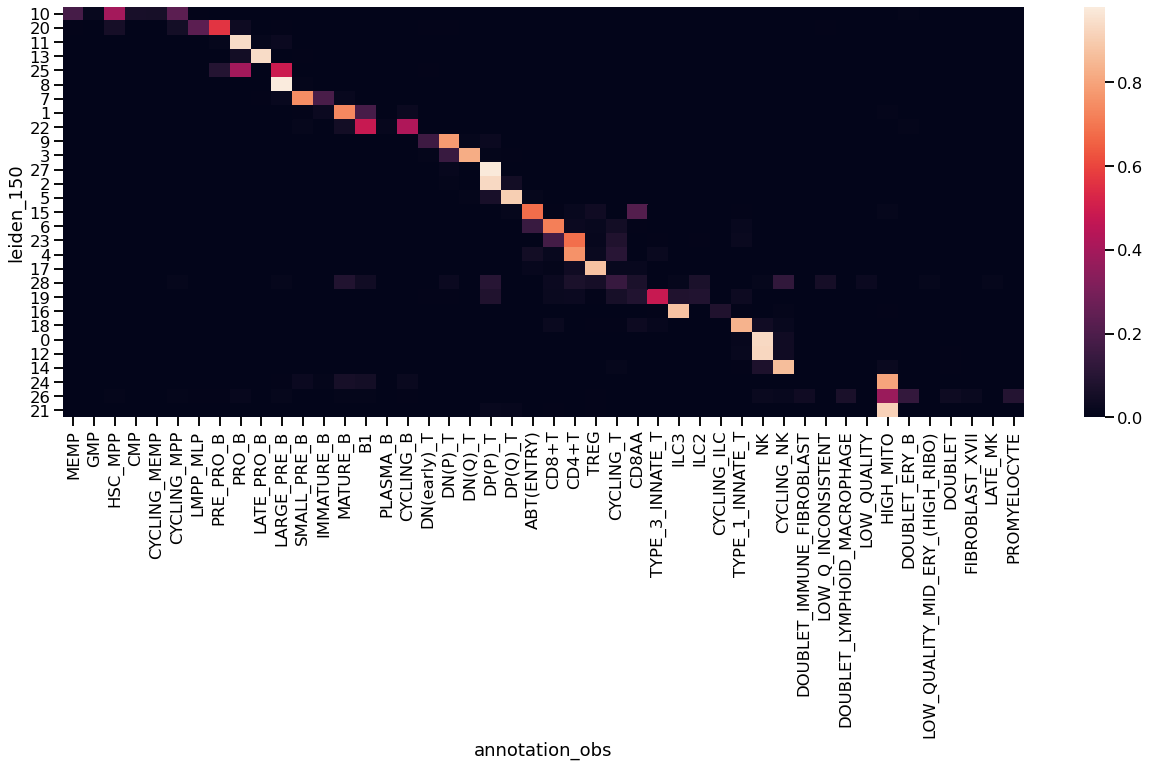

In [193]:
sns.set_context('talk')
plt.rcParams['figure.figsize'] = [18,11]
sns.heatmap(conf_mat.T, xticklabels=True, yticklabels=True);
plt.tight_layout();
plt.savefig(figdir + 'LYMPHOID_NEW_confusion_mat.pdf')

### Marker dotplot

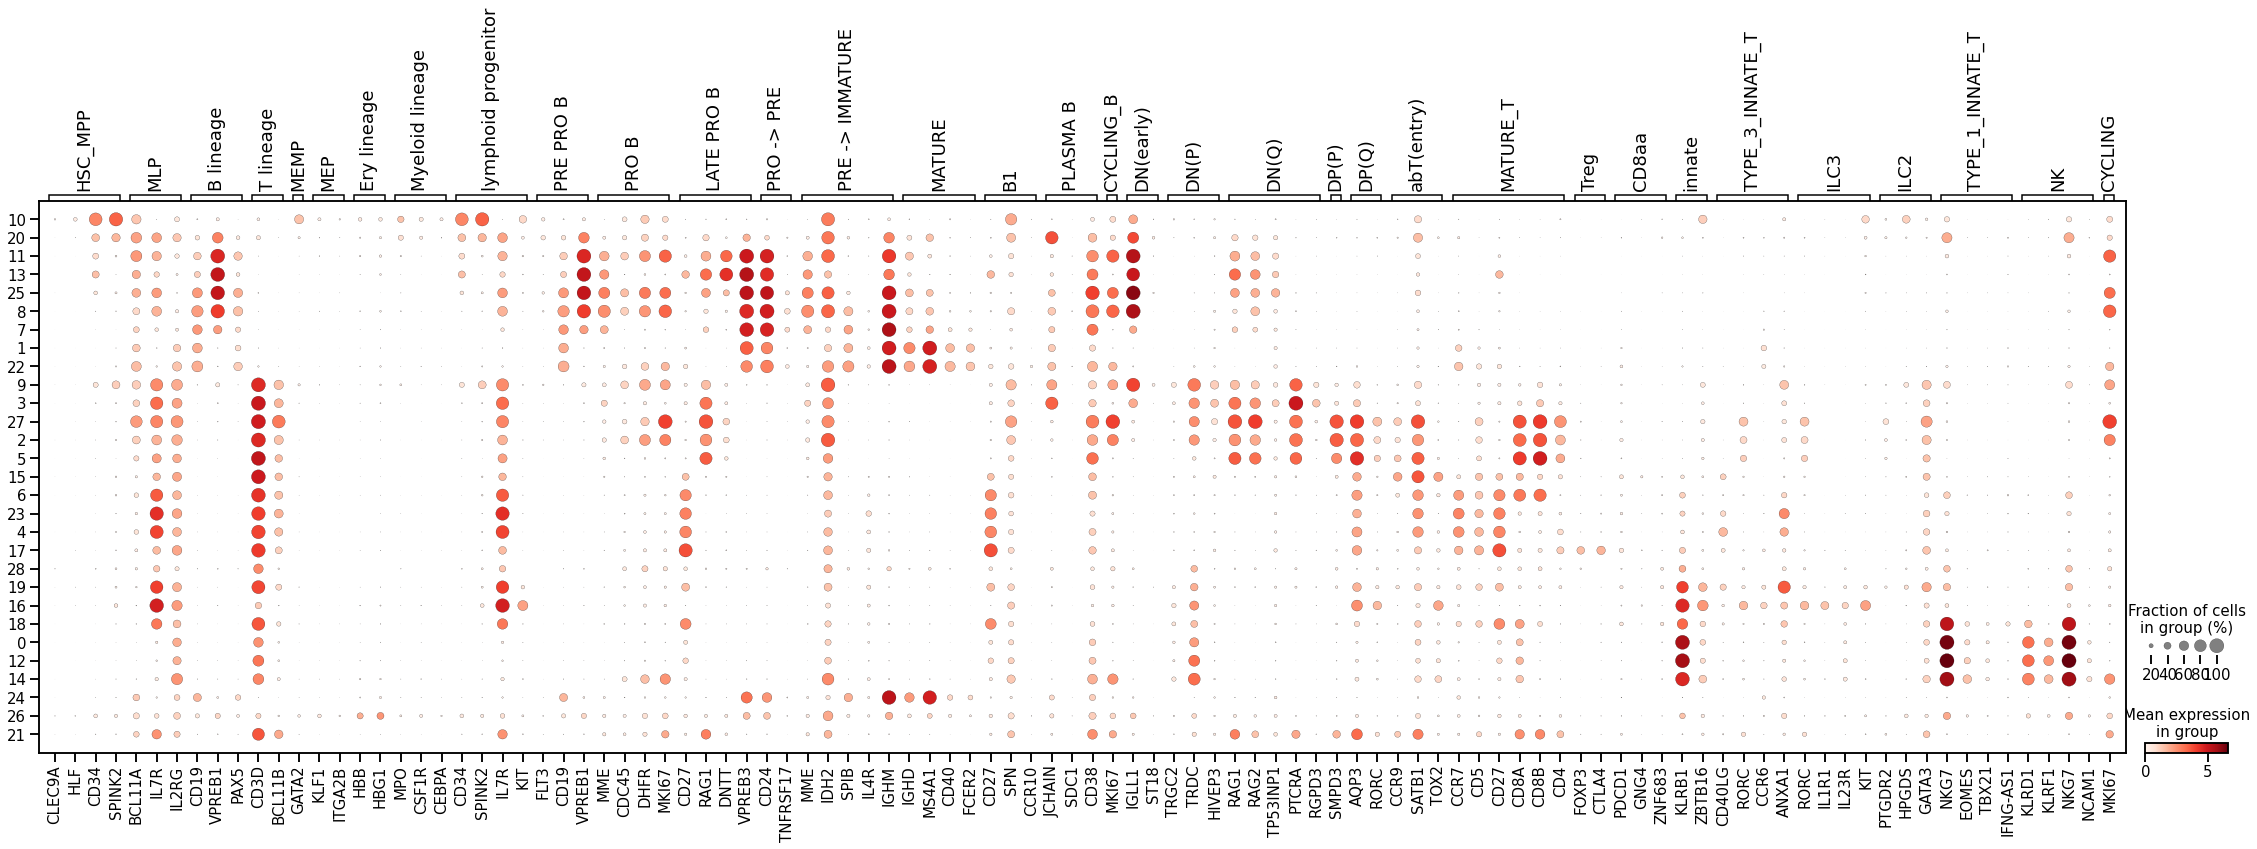

In [194]:
sc.pl.dotplot(adata, markers, 'leiden_150', categories_order=col_order, swap_axes=False,
              dendrogram=False, use_raw=False, save='LYMPHOID_NEW_dotplot.pdf')

### Annotation round 1
To find low quality clusters

In [195]:
new_cluster_names = dict(zip(conf_mat.idxmax().index, conf_mat.idxmax().values))
new_cluster_names

{'10': 'HSC_MPP',
 '20': 'PRE_PRO_B',
 '11': 'PRO_B',
 '13': 'LATE_PRO_B',
 '25': 'LARGE_PRE_B',
 '8': 'LARGE_PRE_B',
 '7': 'SMALL_PRE_B',
 '1': 'MATURE_B',
 '22': 'B1',
 '9': 'DN(P)_T',
 '3': 'DN(Q)_T',
 '27': 'DP(P)_T',
 '2': 'DP(P)_T',
 '5': 'DP(Q)_T',
 '15': 'ABT(ENTRY)',
 '6': 'CD8+T',
 '23': 'CD4+T',
 '4': 'CD4+T',
 '17': 'TREG',
 '28': 'CYCLING_T',
 '19': 'TYPE_3_INNATE_T',
 '16': 'ILC3',
 '18': 'TYPE_1_INNATE_T',
 '0': 'NK',
 '12': 'NK',
 '14': 'CYCLING_NK',
 '24': 'HIGH_MITO',
 '26': 'HIGH_MITO',
 '21': 'HIGH_MITO'}

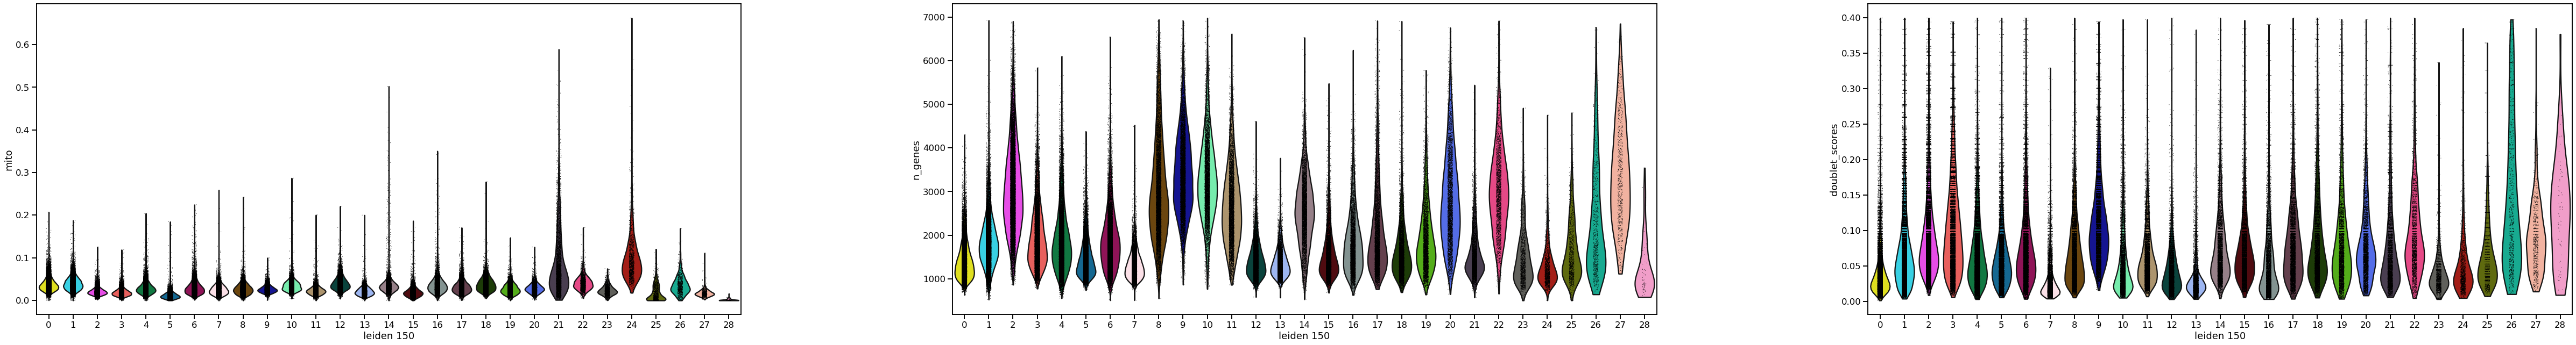

In [207]:
sc.pl.violin(adata, ['mito', 'n_genes','doublet_scores'],groupby='leiden_150', ncol=1)

Proposed updated annotation

In [212]:
new_cluster_names_checked = {
    '10': 'HSC_MPP', # to be annotated w progenitors
 '20': 'MLP_PRE_PRO_B', # mix
 '11': 'PRO_B',
 '13': 'LATE_PRO_B',
 '25': 'LOW_Q_B_PROGENITORS', # very odd shape and QC metrics similar to other lowQ clusters, Chenqu pls check!!
 '8': 'LARGE_PRE_B',
 '7': 'SMALL_PRE_B',
 '1': 'MATURE_B',
 '22': 'B1',
 '9': 'DN(P)_T',
 '3': 'DN(Q)_T',
 '27': 'LOW_Q_DP_T', ## check
 '2': 'DP(P)_T',
 '5': 'DP(Q)_T',
 '15': 'ABT(ENTRY)',
 '6': 'CD8+T',
 '23': 'CD4+T', ## check
 '4': 'CD4+T',
 '17': 'TREG',
 '28': 'DOUBLETS', ## check
 '19': 'TYPE_3_INNATE_T', ## this is an interesting one if you look on UMAP
    ## what if we have found the gdT cells??
 '16': 'ILC3',
 '18': 'TYPE_1_INNATE_T',
 '0': 'NK',
 '12': 'NK',
 '14': 'CYCLING_NK',
 '24': 'HIGH_MITO',
 '26': 'HIGH_MITO',
 '21': 'HIGH_MITO'}

## Which clusters to exclude as low quality for new embedding?
flag_low_q = ['HIGH_MITO', 'DOUBLETS', 'LOW_Q_B_PROGENITORS']

adata.obs['annotation_4qc'] = [new_cluster_names_checked[x] for x in adata.obs['leiden_150']]

highQ_obs = adata.obs_names[~adata.obs['annotation_4qc'].isin(flag_low_q)]

### Save postQC cells

In [213]:
adata_raw = sc.read_h5ad(data_dir + f"PAN.A01.v01.entire_data_raw_count.20210429.{spl}.h5ad")

## Re-save raw object post-QC
sdata = adata[highQ_obs].copy()
sdata.write_h5ad('{d}PAN.A01.v01.entire_data_normalised_log.20210429.LYMPHOID_NEW_POSTQC.h5ad'.format(d=data_dir))
sdata_raw = adata_raw[highQ_obs].copy() 
sdata_raw.write_h5ad('{d}PAN.A01.v01.entire_data_raw_count.20210429.{s}_POSTQC.h5ad'.format(d=data_dir, s=spl))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'annotation_4qc' as categorical
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## MYELOID_NEW

In [137]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/'
spl = 'MYELOID_NEW'

adata = sc.read_h5ad(data_dir + f"PAN.A01.v01.entire_data_normalised_log.20210429.{spl}.h5ad")
adata.var_names_make_unique()

## Load old annotations
adata.obs['annotation_obs'] = obs.loc[adata.obs_names]['anno_lvl_2_final_clean']

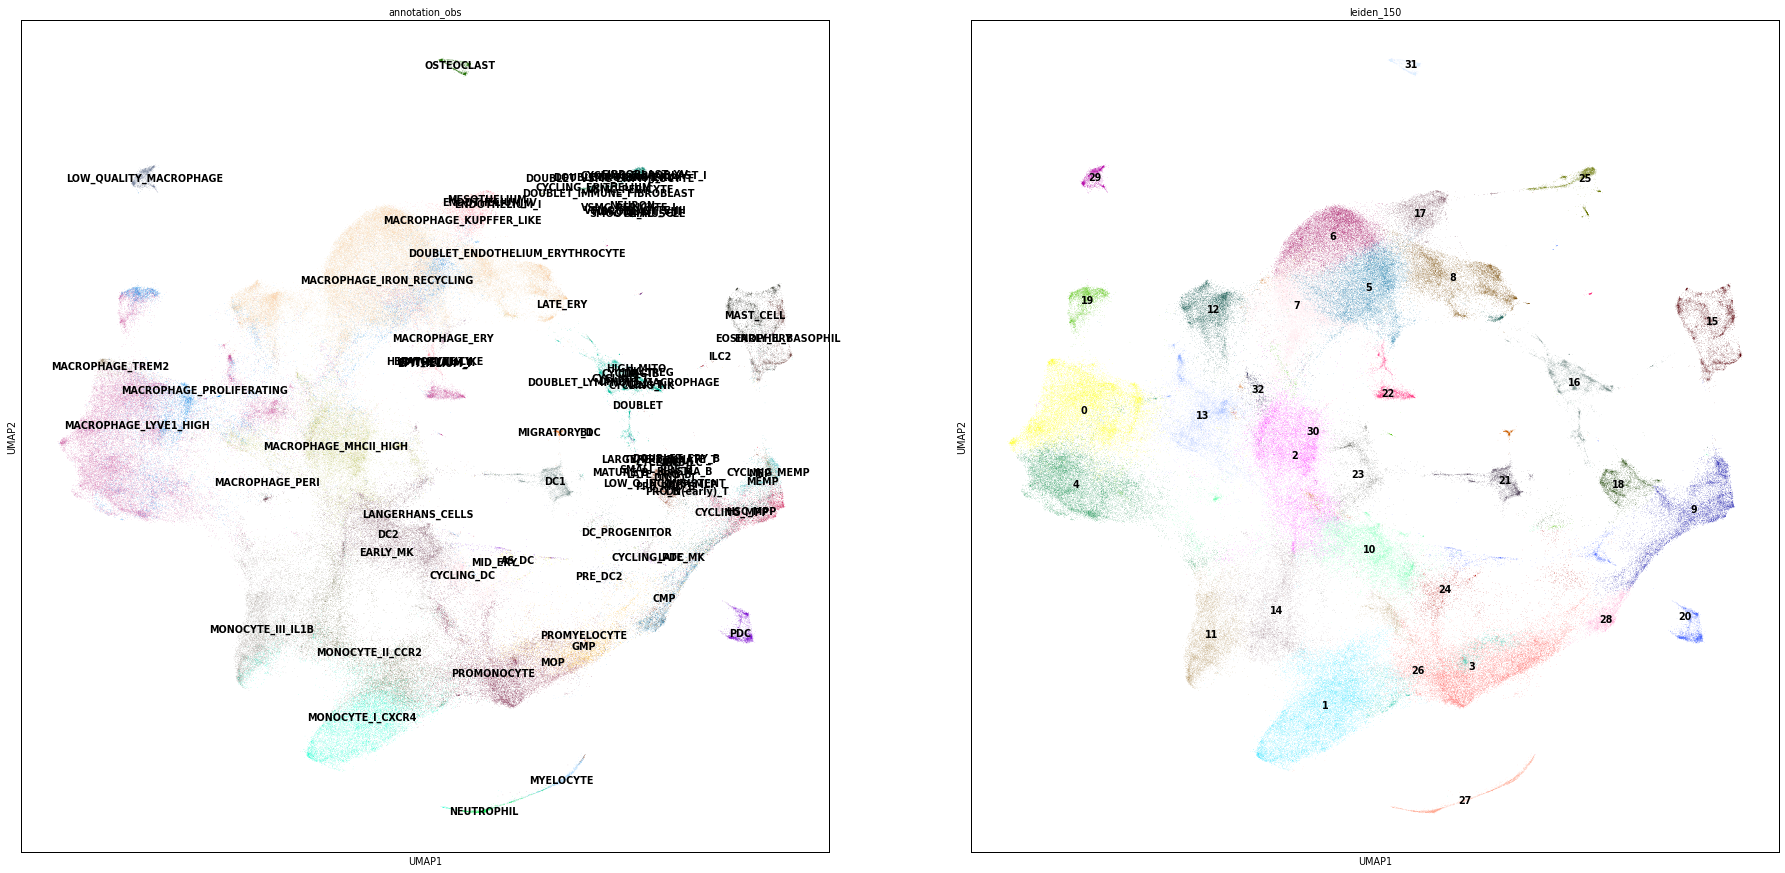

In [140]:
plt.rcParams['figure.figsize'] = [15,15]
sns.set_context("paper")
sc.pl.umap(adata, color=['annotation_obs', 'leiden_150'], legend_loc='on data', save='UMAPs_MYELOID_NEW.png')

In [146]:
# markers = pd.read_csv('../../metadata/marker_genes/B_marker_genes_09072021_clean.csv', index_col=0)
# markers_dict = {a:markers.loc[markers['anno_lvl_2']==a, 'gene'].tolist() for a in markers['anno_lvl_2'].unique()}
markers = {
            ## Progenitors
            'HSC_MPP':['CLEC9A','HLF','CD34','SPINK2'],
           'MLP':['BCL11A','IL7R','IL2RG'],
           'B lineage':['CD19','VPREB1','PAX5'],
           'T lineage':['CD3D','BCL11B'],
           'MEMP':['GATA2'],
           'MEP':['KLF1','ITGA2B'],
           'Ery lineage':['HBB','HBG1'],
           'Myeloid lineage':['MPO','CSF1R','CEBPA'],
    ## Myeloid 
    'Early Progenitor':["CD34",	"SPINK2",	"MLLT3"],
'Myeloid_progenitor':["PRSS57",	"PRTN3",	"AZU1",],
'Neutrophil lineage':["ELANE",	"DEFA4",	"LCN2",	"LTF",	"ORM1",],
'Monocyte_lineage':["CD52",	"S100A8",	"MS4A6A",	"CD14",	"CXCR4",	"CCR2",	"IL1B",	"CD300E",],
'DC_progenitor':["ACY3",	"TIFAB",	"KIF17",],
'pDC':["CLEC4C",	"JCHAIN",	"IRF7",],
'ASDC':["SIGLEC6",	"AXL",],
'DC2':["CLEC10A",	"CD1C",],
'DC1':["CLEC9A",	"BATF3",],
'MIGRATORY_DC':["CCR7",	"LAMP3",],
'LANGERHANS_CELLS':["IDO1","CD207",	"CD1A",],
'EO_BASO_MAST':["CLC",	"KIT",	"TPSAB1",],
'MACROPHAGE_LYVE1_HIGH':["F13A1",	"LYVE1",	"SPP1",],
 'MACROPHAGE_IRON_RECYCLING':["CD5L",	"APOE",	"VCAM1",],
 'MACROPHAGE_PROLIFERATING':["TOP2A",	"MKI67",],
 'MACROPHAGE_MHCII_HIGH':["HLA-DRA",	"HLA-DPA1",	"CLEC7A",],
 'MACROPHAGE_KUPFFER_LIKE':["ENG",	"KDR",	"CAV1",],
 'MACROPHAGE_TREM2':["TREM2",	"P2RY12",],
'OSTEOCLAST':["MMP9",	"ACP5",]
    #
          }

cell_type_order = [
 'PROMYELOCYTE',
 'MYELOCYTE',
 'NEUTROPHIL',
 'MOP',
 'PROMONOCYTE',
 'MONOCYTE_I_CXCR4',
 'MONOCYTE_II_CCR2',
 'MONOCYTE_III_IL1B',
 'DC_PROGENITOR',
 'PDC',
 'CYCLING_PDC',
'AS_DC',
 'PRE_DC2',
 'CYCLING_DC',
 'DC2',
 'DC1',
 'MIGRATORY_DC',
'LANGERHANS_CELLS',
'EOSINOPHIL_BASOPHIL',
 'MAST_CELL',
'MACROPHAGE_LYVE1_HIGH',
 'MACROPHAGE_IRON_RECYCLING',
 'MACROPHAGE_PROLIFERATING',
 'MACROPHAGE_MHCII_HIGH',
 'MACROPHAGE_KUPFFER_LIKE',
 'MACROPHAGE_TREM2',
 'OSTEOCLAST'
]

cell_type_order = anno_groups_dict['PROGENITORS'] + cell_type_order + anno_groups_dict['OTHER']
# anno_groups_dict['PROGENITORS']

### Confusion matrix

In [147]:
conf_mat = sc.metrics.confusion_matrix( 'leiden_150', 'annotation_obs', adata.obs, normalize=True).T

## Keep cts that make up at least 1% of a cluster
keep_cts_ixs = np.where(conf_mat.max(1) > 0.01)[0] 
conf_mat = conf_mat.iloc[keep_cts_ixs]

## Reorder annotations
conf_mat_order = [x for x in cell_type_order if x in conf_mat.index] + conf_mat.index[~conf_mat.index.isin(cell_type_order)].tolist()
conf_mat = conf_mat.loc[conf_mat_order]

## Sort to have some sort of diagonal
col_order = conf_mat.idxmax(0).astype('category').cat.set_categories(cell_type_order).sort_values().index
conf_mat = conf_mat[col_order]

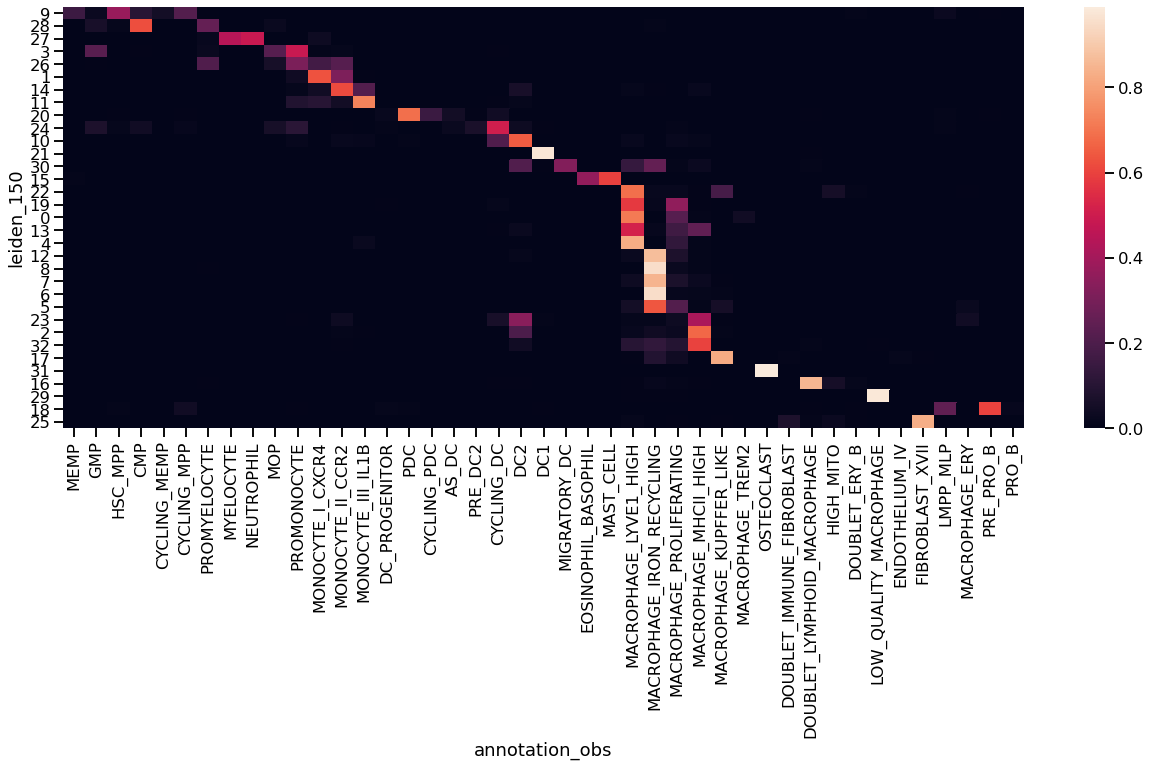

In [148]:
sns.set_context('talk')
plt.rcParams['figure.figsize'] = [18,11]
sns.heatmap(conf_mat.T, xticklabels=True, yticklabels=True);
plt.tight_layout();
plt.savefig(figdir + 'MYELOID_NEW_confusion_mat.pdf')

### Marker dotplot

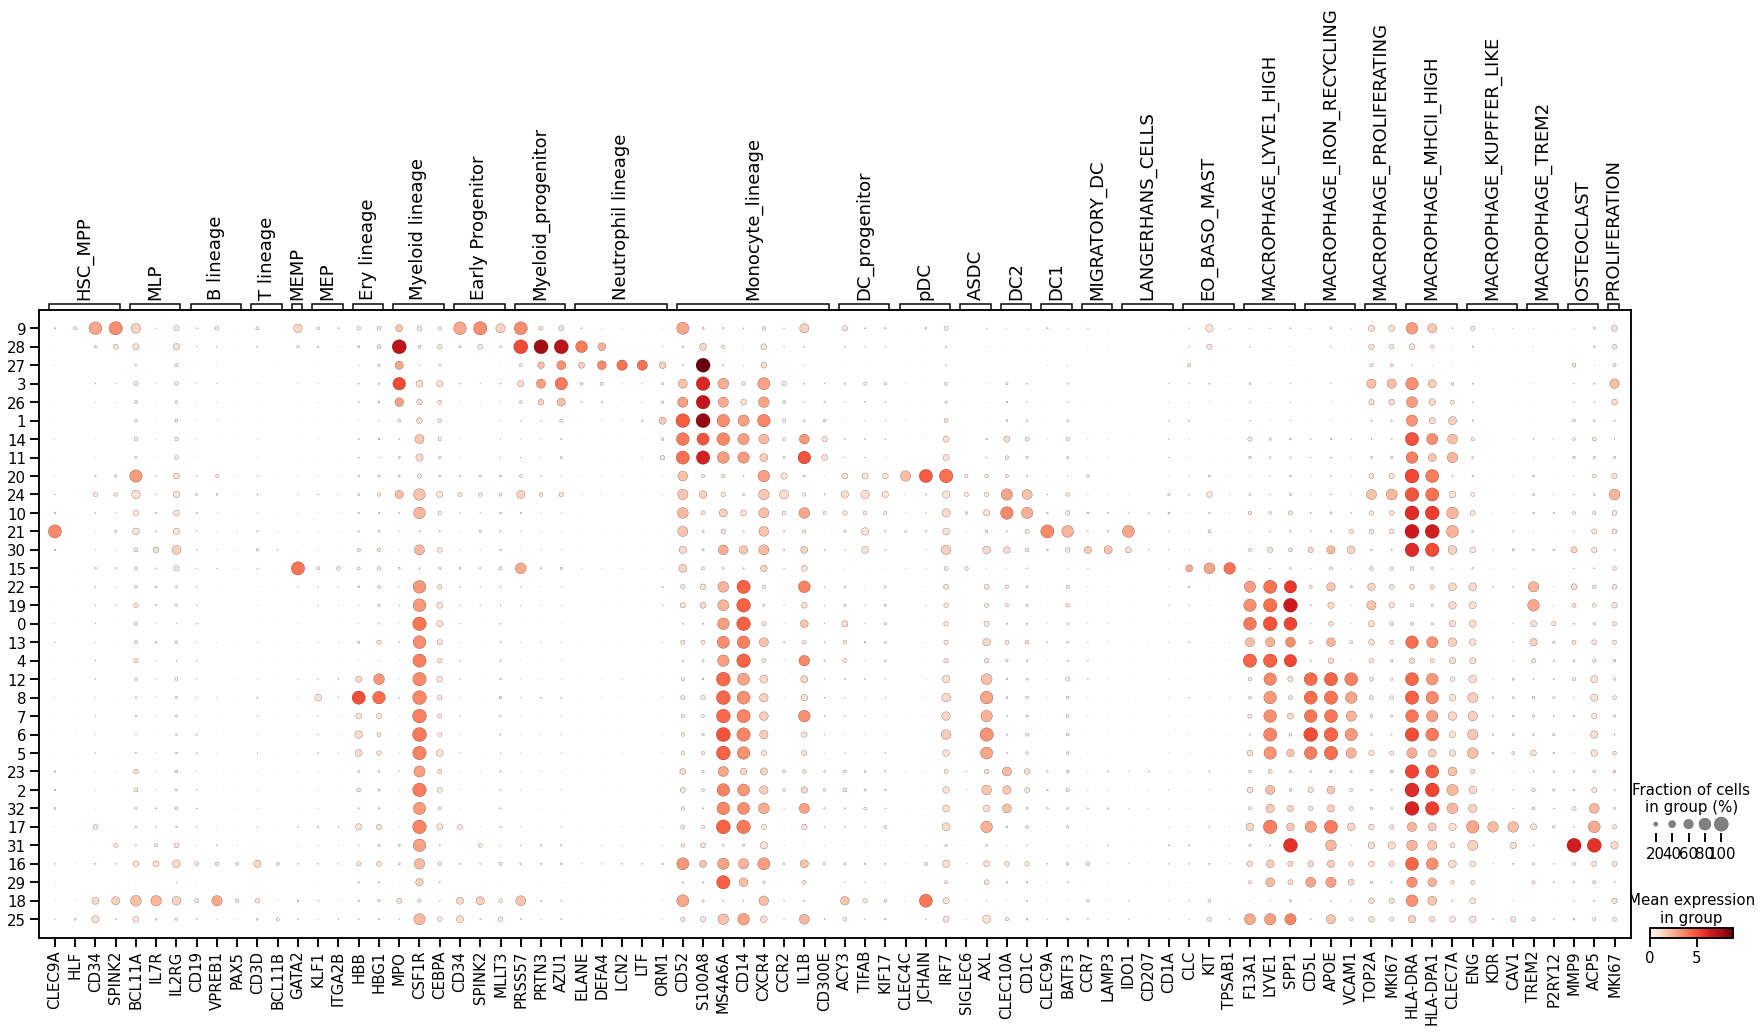

In [164]:
markers['PROLIFERATION'] = ['MKI67']
sc.pl.dotplot(adata, markers, 'leiden_150', categories_order=col_order, swap_axes=False,
              dendrogram=False, use_raw=False, save='MYELOID_NEW_dotplot.pdf')

### Annotation round 1

In [172]:
new_cluster_names = dict(zip(conf_mat.idxmax().index, conf_mat.idxmax().values))

Proposed updated annotation

In [177]:
new_cluster_names_checked = {'9': 'HSC_MPP', ## to be annotated w progenitors
 '28': 'CMP',
 '27': 'NEUTROPHIL',
 '3': 'PROMONOCYTE',
 '26': 'PROMONOCYTE',
 '1': 'MONOCYTE_I_CXCR4',
 '14': 'MONOCYTE_II_CCR2',
 '11': 'MONOCYTE_III_IL1B',
 '20': 'PDC',
 '24': 'CYCLING_DC2', ## based on marker expression
 '10': 'DC2',
 '21': 'DC1',
 '30': 'MIGRATORY_DC', ## This one is a mix of migDCs and macs?
 '15': 'EO_BASO_MAST_CELL', # Mix?
 ## Redefined TREM2hi/YS macs, two distinct clusters, I wouldn't merge
 '22': 'MACROPHAGE_TREM2_II', # main distinction I could notice: cl22 is IL1Bhi
 '19': 'MACROPHAGE_TREM2_I', 
 '0': 'MACROPHAGE_LYVE1_HIGH',
 '13': 'MACROPHAGE_LYVE1_HIGH_MHCII_HIGH', # mix?
 '4': 'MACROPHAGE_LYVE1_HIGH',
 '12': 'MACROPHAGE_IRON_RECYCLING',
 '8': 'MACROPHAGE_IRON_RECYCLING', # Mac_ery maybe?
 '7': 'MACROPHAGE_IRON_RECYCLING',
 '6': 'MACROPHAGE_IRON_RECYCLING',
 '5': 'MACROPHAGE_IRON_RECYCLING',
 '23': 'MACROPHAGE_MHCII_HIGH',
 '2': 'MACROPHAGE_MHCII_HIGH',
 '32': 'MACROPHAGE_MHCII_HIGH',
 '17': 'MACROPHAGE_KUPFFER_LIKE',
 '31': 'OSTEOCLAST',
 '16': 'DOUBLET_LYMPHOID_MACROPHAGE',
 '29': 'LOW_QUALITY_MACROPHAGE',
 '18': 'PROGENITORS', ## to be annotated w progenitors
 '25': 'FIBROBLAST_XVII'
}

## Which clusters to exclude as low quality for new embedding?
flag_low_q = ['DOUBLET_LYMPHOID_MACROPHAGE', 'LOW_QUALITY_MACROPHAGE', 'FIBROBLAST_XVII']

adata.obs['annotation_4qc'] = [new_cluster_names_checked[x] for x in adata.obs['leiden_150']]

highQ_obs = adata.obs_names[~adata.obs['annotation_4qc'].isin(flag_low_q)]

### Save postQC cells

In [182]:
adata_raw = sc.read_h5ad(data_dir + f"PAN.A01.v01.entire_data_raw_count.20210429.{spl}.h5ad")

In [186]:
## Re-save raw object post-QC
sdata = adata[highQ_obs].copy()
sdata.write_h5ad('{d}PAN.A01.v01.entire_data_normalised_log.20210429.MYELOID_NEW_POSTQC.h5ad'.format(d=data_dir))
sdata_raw = adata_raw[highQ_obs].copy() 
sdata_raw.write_h5ad('{d}PAN.A01.v01.entire_data_raw_count.20210429.{s}_POSTQC.h5ad'.format(d=data_dir, s=spl))

... storing 'annotation_4qc' as categorical
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
